In [ ]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [ ]:
# Load the datasets
train_df = pd.read_csv('/content/drive/MyDrive/FYP_2024/Final_Train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/FYP_2024/Final_test.csv')
validation_df = pd.read_csv('/content/drive/MyDrive/FYP_2024/Final_Validation.csv')

In [ ]:
# Function to preprocess datasets
def preprocess_data(df):
    df['local_time'] = pd.to_datetime(df['local_time'])
    for time_unit in ['Year', 'Month', 'Day', 'Hour']:
        df[time_unit] = getattr(df['local_time'].dt, time_unit.lower())
    return df.drop('local_time', axis=1)

In [ ]:
def add_cyclical_features(df, col_name, max_val):
    if col_name in df.columns:
        df[col_name + '_sin'] = np.sin(2 * np.pi * df[col_name] / max_val)
        df[col_name + '_cos'] = np.cos(2 * np.pi * df[col_name] / max_val)
    return df

#'Hour', 'Day', and 'Month' created
for df in [train_df, validation_df, test_df]:
    df = add_cyclical_features(df, 'Hour', 23)
    df = add_cyclical_features(df, 'Day', 31)
    df = add_cyclical_features(df, 'Month', 12)

In [ ]:
def add_lagged_features(df, feature_cols, n_lags=3):
    for feature in feature_cols:
        for lag in range(1, n_lags + 1):
            df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
    return df.dropna().reset_index(drop=True)

# Preprocess all datasets
train_df = preprocess_data(train_df)
test_df = preprocess_data(test_df)
validation_df = preprocess_data(validation_df)

# Specifying the features to lag
features_to_lag = ['Average_Temp', 'MW']  # Add other relevant features as needed

# Applying the function to the datasets
train_df = add_lagged_features(train_df, features_to_lag, n_lags=3)
validation_df = add_lagged_features(validation_df, features_to_lag, n_lags=3)
test_df = add_lagged_features(test_df, features_to_lag, n_lags=3)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

# Creating polynomial and interaction features
poly = PolynomialFeatures(degree=2, include_bias=False)

# Applying transformation to all datasets.
train_features = train_df.drop(columns=['MW'])
validation_features = validation_df.drop(columns=['MW'])
test_features = test_df.drop(columns=['MW'])

X_train_poly = poly.fit_transform(train_features)
X_validation_poly = poly.transform(validation_features)
X_test_poly = poly.transform(test_features)


feature_names = poly.get_feature_names_out(input_features=train_features.columns)


y_train = train_df['MW']
y_validation = validation_df['MW']
y_test = test_df['MW']

In [ ]:
# Evaluation Function

def calculate_metrics(actual, predicted, lower_bound=0, upper_bound=100, iqr_multiplier=1.5):
    # Excluding negative actual values if considered invalid
    valid_indices = actual > lower_bound
    actual = actual[valid_indices]
    predicted = predicted[valid_indices]

    # Calculate MAE and RMSE
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))

    # Thresholding for outlier exclusion based on IQR
    q1, q3 = np.percentile(actual, [25, 75])
    iqr = q3 - q1
    outlier_threshold_upper = q3 + (iqr * iqr_multiplier)
    outlier_threshold_lower = q1 - (iqr * iqr_multiplier)

    valid_indices_for_mape = (actual >= outlier_threshold_lower) & (actual <= outlier_threshold_upper)
    filtered_actual = actual[valid_indices_for_mape]
    filtered_predicted = predicted[valid_indices_for_mape]

    # Calculate Modified MAPE with capped at 100%
    if len(filtered_actual) > 0:
        percentage_errors = np.abs((filtered_predicted - filtered_actual) / filtered_actual) * 100
        percentage_errors = np.clip(percentage_errors, None, upper_bound)  # Cap percentage errors at upper_bound (100%)
        mape = np.mean(percentage_errors)
    else:
        mape = np.nan

    # Calculate sMAPE
    smape = 100/len(actual) * np.sum(2 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted)))

    return mae, mape, smape, rmse

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import numpy as np
from sklearn.metrics import mean_squared_error

# ARIMA Model Setup with Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)
best_arima_order = (1, 1, 1)  # Initial default order
best_arima_score = float("inf")

for train_index, test_index in tscv.split(y_train):
    cv_train, cv_test = y_train.iloc[train_index], y_train.iloc[test_index]

    for p in range(1, 4):  # Expanded search space
        for d in range(0, 3):
            for q in range(0, 4):
                try:
                    model = ARIMA(cv_train, order=(p, d, q))
                    results = model.fit()
                    predictions = results.forecast(steps=len(cv_test))
                    score = mean_squared_error(cv_test, predictions)

                    if score < best_arima_score:
                        best_arima_score = score
                        best_arima_order = (p, d, q)
                except:
                    continue

# Fit ARIMA model with the best order found
best_arima_model = ARIMA(y_train, order=best_arima_order).fit()

# XGBoost Model Setup with GridSearchCV including Regularization Parameters
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
parameters = {
    'n_estimators': [100, 200, 300],  # Expanded range
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    'lambda': [1, 1.5],  # L2 regularization
    'alpha': [0, 0.5]  # L1 regularization
}
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=parameters, scoring='neg_mean_squared_error')
grid_search_xgb.fit(X_train_poly, y_train)
best_xgb_model = grid_search_xgb.best_estimator_

# Predictions from the best XGBoost and ARIMA models
xgb_pred = best_xgb_model.predict(X_test_poly)
arima_pred = best_arima_model.forecast(steps=len(y_test))

# Combining predictions based on thresholds
T1 = 71.54
T2 = 156.97
final_predictions = np.where(arima_pred < T1, xgb_pred, np.where(arima_pred < T2, arima_pred, xgb_pred))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/st

In [ ]:
from joblib import dump

# Save the best XGBoost model
dump(best_xgb_model, '/content/drive/MyDrive/Saved_trained_models/best_xgb_model_hybrid.joblib')

# Save the best ARIMA model
dump(best_arima_model, '/content/drive/MyDrive/Saved_trained_models/best_arima_model_hybrid.joblib')


['/content/drive/MyDrive/Saved_trained_models/best_arima_model_hybrid.joblib']

In [ ]:
from joblib import load
# Load the best ARIMA model
best_arima_model = load('/content/drive/MyDrive/Saved_trained_models/best_arima_model_hybrid.joblib')

# Load the best XGBoost model
best_xgb_model = load('/content/drive/MyDrive/Saved_trained_models/best_xgb_model_hybrid.joblib')

In [ ]:
arima_pred_train = best_arima_model.predict(start=1, end=len(train_df))
arima_pred_validation = best_arima_model.predict(start=len(train_df) + 1, end=len(train_df) + len(validation_df))
arima_pred_test = best_arima_model.forecast(steps=len(test_df))

# XGBoost predictions remain the same
xgb_pred_train = best_xgb_model.predict(X_train_poly)
xgb_pred_validation = best_xgb_model.predict(X_validation_poly)
xgb_pred_test = best_xgb_model.predict(X_test_poly)

# Combination Logic for Final Predictions, corrected to reflect proper usage
T1 = 71.54
T2 = 156.97

final_predictions_train = np.where(arima_pred_train < T1, xgb_pred_train, np.where(arima_pred_train < T2, arima_pred_train, xgb_pred_train))
final_predictions_validation = np.where(arima_pred_validation < T1, xgb_pred_validation, np.where(arima_pred_validation < T2, arima_pred_validation, xgb_pred_validation))
final_predictions_test = np.where(arima_pred_test < T1, xgb_pred_test, np.where(arima_pred_test < T2, arima_pred_test, xgb_pred_test))


# Evaluation (make sure you have the correct actual values for y_train, y_validation, and y_test)
train_mae, train_mape, train_smape, train_rmse = calculate_metrics(y_train, final_predictions_train)
validation_mae, validation_mape, validation_smape, validation_rmse = calculate_metrics(y_validation, final_predictions_validation)
test_mae, test_mape, test_smape, test_rmse = calculate_metrics(y_test, final_predictions_test)
test_metrics = [test_mae, test_mape, test_smape, test_rmse]

print(f"Train Metrics:\nMAE: {train_mae}, MAPE: {train_mape}, sMAPE: {train_smape}, RMSE: {train_rmse}")
print(f"Validation Metrics:\nMAE: {validation_mae}, MAPE: {validation_mape}, sMAPE: {validation_smape}, RMSE: {validation_rmse}")
print(f"Test Metrics:\nMAE: {test_mae}, MAPE: {test_mape}, sMAPE: {test_smape}, RMSE: {test_rmse}")

Train Metrics:
MAE: 4.611991603871445, MAPE: 7.7273647948908915, sMAPE: 7.61909002171122, RMSE: 10.728558329555781
Validation Metrics:
MAE: 7.853686148978332, MAPE: 12.776751916248491, sMAPE: 12.974225898338204, RMSE: 18.234073556662278
Test Metrics:
MAE: 6.596313251394527, MAPE: 7.1565136204196245, sMAPE: 9.018021366599086, RMSE: 16.087852557314825


In [ ]:
best_xgb_params = best_xgb_model.get_params()
print(best_xgb_params)


{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'alpha': 0, 'lambda': 1}


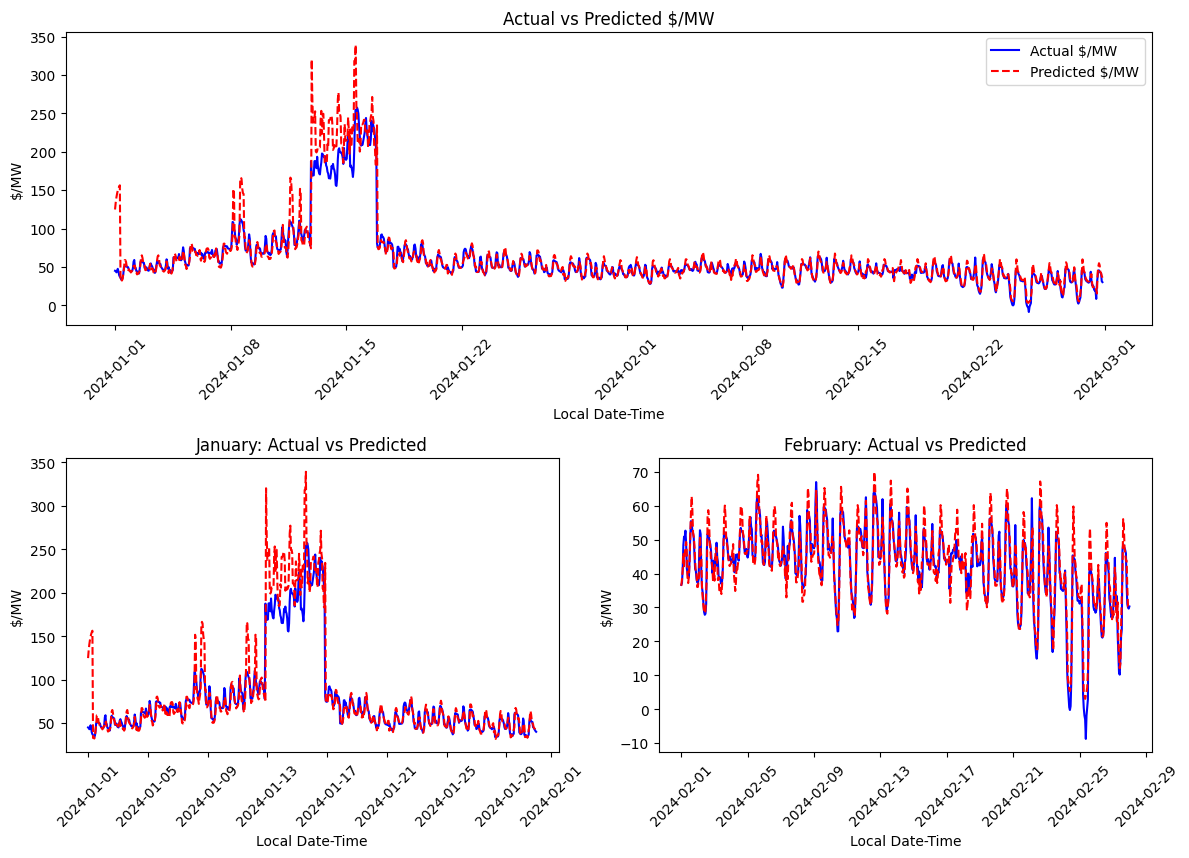

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

test_df_for_plotting = pd.read_csv('/content/drive/MyDrive/FYP_2024/Final_test.csv', usecols=['local_time'])
test_local_time = pd.to_datetime(test_df_for_plotting['local_time'])

if len(test_local_time) > len(final_predictions_test):
    test_local_time = test_local_time[:len(final_predictions_test)]

# Convert 'test_local_time' to datetime if it's not already
test_local_time = pd.to_datetime(test_local_time)

# Filter for January
january_start = "2024-01-01"
january_end = "2024-01-31"
is_january = (test_local_time >= january_start) & (test_local_time <= january_end)
january_times = test_local_time[is_january]
january_actual = y_test[is_january]
january_predictions = final_predictions_test[is_january]

# Filter for February
february_start = "2024-02-01"
february_end = "2024-02-28"
is_february = (test_local_time >= february_start) & (test_local_time <= february_end)
february_times = test_local_time[is_february]
february_actual = y_test[is_february]
february_predictions = final_predictions_test[is_february]

# Set up the plot layout
plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(3, 2)  # Define a grid of 3 rows and 2 columns

# Main plot spanning the first row
ax0 = plt.subplot(gs[0, :])  # This subplot takes up the first row
ax0.plot(test_local_time, y_test, label='Actual $/MW', color='blue')
ax0.plot(test_local_time, final_predictions_test, label='Predicted $/MW', color='red', linestyle='--')
ax0.set_title('Actual vs Predicted $/MW')
ax0.set_xlabel('Local Date-Time')
ax0.set_ylabel('$/MW')
ax0.legend()
ax0.tick_params(axis='x', rotation=45)

# January subplot in the second row, first column
ax1 = plt.subplot(gs[1, 0])  # Bottom left
ax1.plot(january_times, january_actual, label='Actual $/MW', color='blue')
ax1.plot(january_times, january_predictions, label='Predicted $/MW', color='red', linestyle='--')
ax1.set_title('January: Actual vs Predicted')
ax1.set_xlabel('Local Date-Time')
ax1.set_ylabel('$/MW')
ax1.tick_params(axis='x', rotation=45)

# February subplot in the second row, second column
ax2 = plt.subplot(gs[1, 1])  # Bottom right
ax2.plot(february_times, february_actual, label='Actual $/MW', color='blue')
ax2.plot(february_times, february_predictions, label='Predicted $/MW', color='red', linestyle='--')
ax2.set_title('February: Actual vs Predicted')
ax2.set_xlabel('Local Date-Time')
ax2.set_ylabel('$/MW')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()  # Adjust layout to make room for all elements
plt.show()

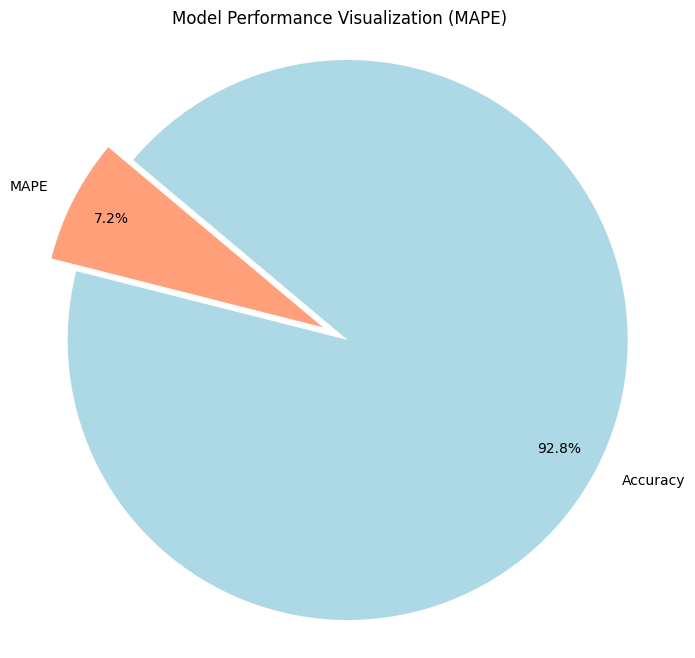

In [ ]:
import matplotlib.pyplot as plt

mape = test_metrics[1]
accuracy = 100 - mape  # Calculating accuracy as the complement of MAPE

# Data for plotting
labels = ['MAPE', 'Accuracy']
sizes = [mape, accuracy]
colors = ['#FFA07A', '#ADD8E6']
explode = (0.1, 0)  # Only explode the MAPE slice

plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, pctdistance=0.85)
plt.axis('equal')
plt.title('Model Performance Visualization (MAPE)')
plt.show()

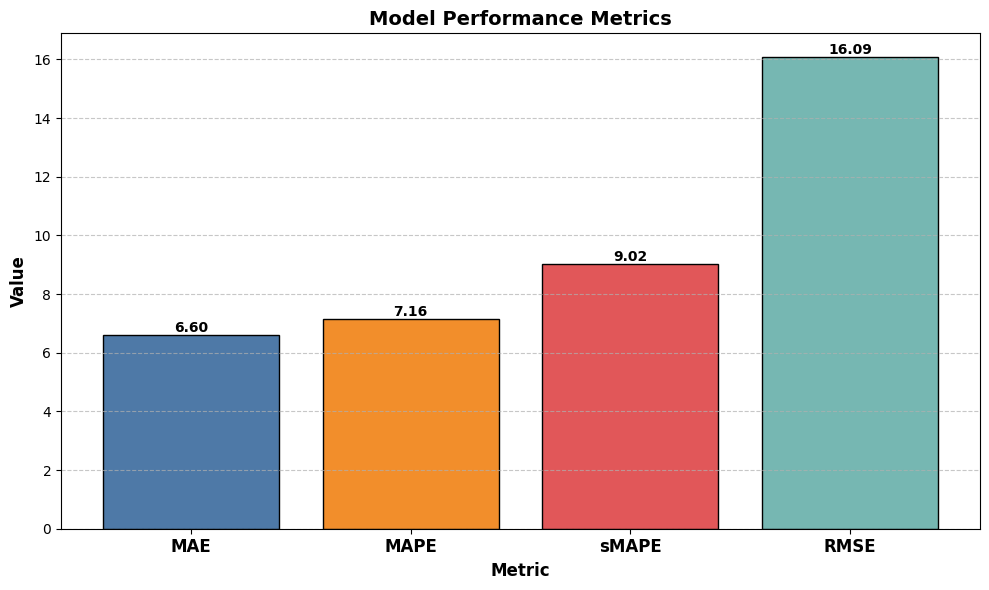

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Metric names
metrics_names = ['MAE', 'MAPE', 'sMAPE', 'RMSE']

# Creating an array with the positions of the bars along the x-axis
x_pos = np.arange(len(metrics_names))

# Plotting the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(x_pos, test_metrics, color=['#4E79A7', '#F28E2B', '#E15759', '#76B7B2'], edgecolor='black')

# Adding the metric names as labels on the x-axis
plt.xticks(x_pos, metrics_names, fontsize=12, fontweight='bold')

# Adding a title and labels for the axes
plt.title('Model Performance Metrics', fontsize=14, fontweight='bold')
plt.xlabel('Metric', fontsize=12, fontweight='bold')
plt.ylabel('Value', fontsize=12, fontweight='bold')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

# Adding gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()